In [22]:
!pip install denoising_diffusion_pytorch
!pip install labml-nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.0/357.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 61.3 MB/s eta 0:00:00


In [9]:
# model = Unet(
#     dim = 64,
#     dim_mults = (1, 2, 4, 8)
# )

# diffusion = GaussianDiffusion(
#     model,
#     image_size = 128,
#     timesteps = 1000,   # number of steps
#     loss_type = 'l1'    # L1 or L2
# )

# training_images = torch.randn(8, 3, 128, 128) # images are normalized from 0 to 1
# loss = diffusion(training_images)
# loss.backward()
# # after a lot of training

# sampled_images = diffusion.sample(batch_size = 4)
# sampled_images.shape # (4, 3, 128, 128)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

In [24]:
# Create a small trajectory as an image
class RandomTrajectory:
    def __init__(self, img_size, step_size, step_number):
        self.img_size = img_size
        self.step_size = step_size
        self.step_number = step_number
        self.curr_id = [0,0] # Indicates the index of the current point to add trajectory
        self.dir_probs = np.array([ # There are 9 possible directions, these are the probabilities of a direction
            [0.01, 0.05,0.11],
            [0.05, 0.01, 0.22], # Going right bottom has the highest probability
            [0.11, 0.22 ,0.22]
        ]).flatten()
        
        self.dirs = np.array([ # Directions of the indices in self.dir_probs correspondingly
            [-1,-1], [-1,0], [-1,+1], 
            [0, -1], [0, 0], [0, +1],
            [+1,-1], [+1,0], [+1,+1]
        ])
        
    def reached_end(self):
        return self.curr_id[0] >= self.img.shape[0] or self.curr_id[1] >= self.img.shape[1]
        
    def reset(self):
        self.img = np.zeros((self.img_size, self.img_size)) # 1s will indicate the trajectory - input of the diffusion model will be a 1 channel img anyways
        self.curr_id = [0,0]
        
    def create_traj(self):
        self.reset()
        for _ in range(self.step_number):
            if self.reached_end():
                break
            self.img[self.curr_id[0], self.curr_id[1]] = 1
            self.add_step()
        print("Trajectory planning finished")
        
    def add_step(self):
        dir_id = np.random.choice(len(self.dir_probs), 1, p=self.dir_probs)[0]
        curr_dir = self.dirs[dir_id]
        while not self.is_dir_possible(curr_dir):
            dir_id = np.random.choice(len(self.dir_probs), 1, p=self.dir_probs)[0]
            curr_dir = self.dirs[dir_id] # All of the trajectories should be feasible
        self.curr_id += self.step_size * curr_dir
        
    def is_dir_possible(self, curr_dir):
        # Check the 1st axis
        is_pos = True
        for curr_ax in range(2):
            if self.curr_id[curr_ax] <= 0:
                if curr_dir[curr_ax] < 0:
                    is_pos = False
            elif self.curr_id[curr_ax] >= self.img_size-1:
                if curr_dir[curr_ax] > 0:
                    is_pos = False 
        return is_pos
        
    def plot(self):
        plt.figure(figsize=(10,10))
        plt.imshow(self.img)
        
rand_traj = RandomTrajectory(128, 1, 500)



Trajectory planning finished


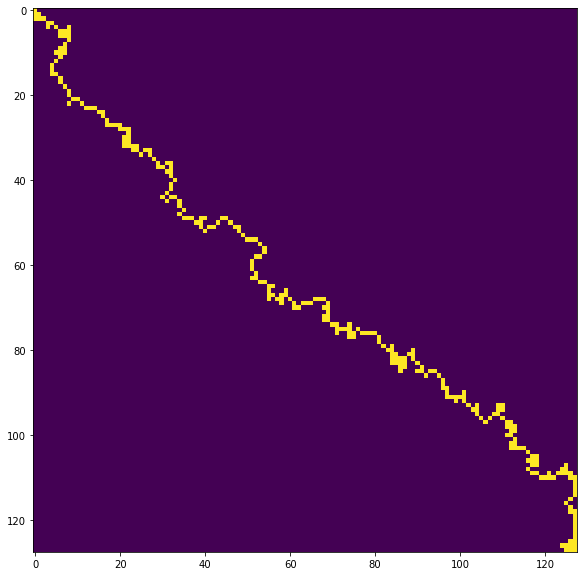

In [25]:
rand_traj.create_traj()
rand_traj.plot()

In [26]:
from typing import Tuple, Optional

import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn
from labml_nn.diffusion.ddpm.utils import gather


class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.eps_model(xt, t)
        alpha_bar = gather(self.alpha_bar, t)
        alpha = gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = gather(self.sigma2, t)

        eps = torch.randn(xt.shape, device=xt.device)
        return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        if noise is None:
            noise = torch.randn_like(x0)

        xt = self.q_sample(x0, t, eps=noise)
        eps_theta = self.eps_model(xt, t)

        return F.mse_loss(noise, eps_theta)

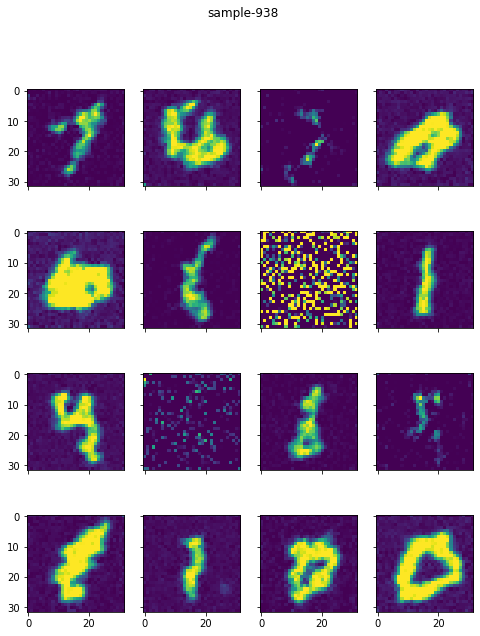

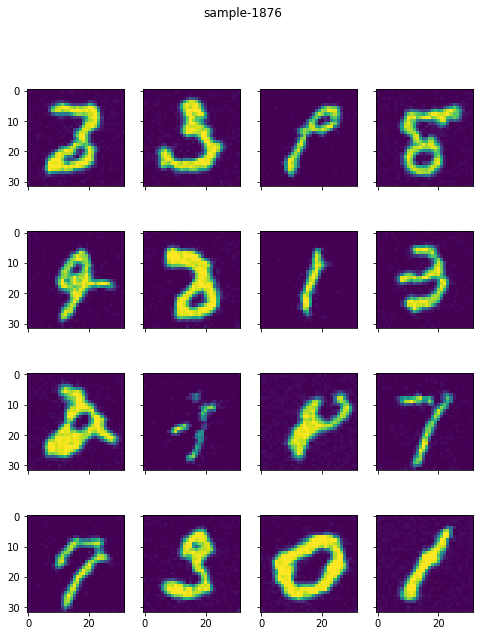

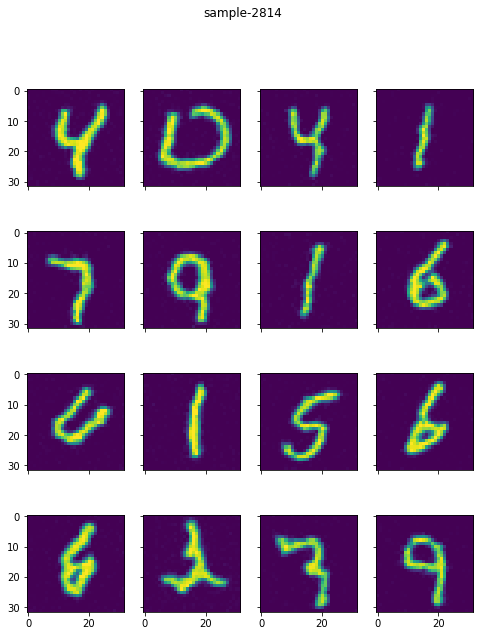

In [ ]:
"""
---
title: Denoising Diffusion Probabilistic Models (DDPM) training
summary: >
  Training code for
  Denoising Diffusion Probabilistic Model.
---

# [Denoising Diffusion Probabilistic Models (DDPM)](index.html) training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/experiment.ipynb)
[![Open In Comet](https://images.labml.ai/images/comet.svg?experiment=capsule_networks&file=model)](https://www.comet.com/labml/diffuse/view/FknjSiKWotr8fgZerpC1sV1cy/panels?utm_source=referral&utm_medium=partner&utm_campaign=labml)

This trains a DDPM based model on CelebA HQ dataset. You can find the download instruction in this
[discussion on fast.ai](https://forums.fast.ai/t/download-celeba-hq-dataset/45873/3).
Save the images inside [`data/celebA` folder](#dataset_path).

The paper had used a exponential moving average of the model with a decay of $0.9999$. We have skipped this for
simplicity.
"""
from typing import List

import torch
import torch.utils.data
import torchvision
from PIL import Image

from labml import lab, tracker, experiment, monit
from labml.configs import BaseConfigs, option
from labml_helpers.device import DeviceConfigs
from labml_nn.diffusion.ddpm import DenoiseDiffusion
from labml_nn.diffusion.ddpm.unet import UNet


class Configs(BaseConfigs):
    """
    ## Configurations
    """
    # Device to train the model on.
    # [`DeviceConfigs`](https://docs.labml.ai/api/helpers.html#labml_helpers.device.DeviceConfigs)
    #  picks up an available CUDA device or defaults to CPU.
    device: torch.device = DeviceConfigs()

    # U-Net model for $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
    eps_model: UNet
    # [DDPM algorithm](index.html)
    diffusion: DenoiseDiffusion

    # Number of channels in the image. $3$ for RGB.
    image_channels: int = 3
    # Image size
    image_size: int = 32
    # Number of channels in the initial feature map
    n_channels: int = 64
    # The list of channel numbers at each resolution.
    # The number of channels is `channel_multipliers[i] * n_channels`
    channel_multipliers: List[int] = [1, 2, 2, 4]
    # The list of booleans that indicate whether to use attention at each resolution
    is_attention: List[int] = [False, False, False, True]

    # Number of time steps $T$
    n_steps: int = 1_000
    # Batch size
    batch_size: int = 64
    # Number of samples to generate
    n_samples: int = 16
    # Learning rate
    learning_rate: float = 2e-5

    # Number of training epochs
    epochs: int = 1_000

    # Dataset
    dataset: torch.utils.data.Dataset
    # Dataloader
    data_loader: torch.utils.data.DataLoader

    # Adam optimizer
    optimizer: torch.optim.Adam

    def init(self):
        # Create $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            is_attn=self.is_attention,
        ).to(self.device)

        # Create [DDPM class](index.html)
        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            device=self.device,
        )

        # Create dataloader
        self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, shuffle=True, pin_memory=True)
        # Create optimizer
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)

        # Image logging
        tracker.set_image("sample", True)

    def sample(self):
        """
        ### Sample images
        """
        with torch.no_grad():
            # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
            x = torch.randn([self.n_samples, self.image_channels, self.image_size, self.image_size],
                            device=self.device)

            # Remove noise for $T$ steps
            for t_ in monit.iterate('Sample', self.n_steps):
                # $t$
                t = self.n_steps - t_ - 1
                # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
                x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long))

            # Log samples
            tracker.save('sample', x)

    def train(self):
        """
        ### Train
        """

        # Iterate through the dataset
        for data in monit.iterate('Train', self.data_loader):
            # Increment global step
            tracker.add_global_step()
            # Move data to device
            data = data.to(self.device)

            # Make the gradients zero
            self.optimizer.zero_grad()
            # Calculate loss
            loss = self.diffusion.loss(data)
            # Compute gradients
            loss.backward()
            # Take an optimization step
            self.optimizer.step()
            # Track the loss
            tracker.save('loss', loss)

    def run(self):
        """
        ### Training loop
        """
        for _ in monit.loop(self.epochs):
            # Train the model
            self.train()
            # Sample some images
            self.sample()
            # New line in the console
            tracker.new_line()
            # Save the model
            experiment.save_checkpoint()

class MNISTDataset(torchvision.datasets.MNIST):
    """
    ### MNIST dataset
    """

    def __init__(self, image_size):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])

        super().__init__(str(lab.get_data_path()), train=True, download=True, transform=transform)

    def __getitem__(self, item):
        return super().__getitem__(item)[0]


@option(Configs.dataset, 'MNIST')
def mnist_dataset(c: Configs):
    """
    Create MNIST dataset
    """
    return MNISTDataset(c.image_size)


def main():
    # Create experiment
    experiment.create(name='diffuse', writers={'screen'})

    # Create configurations
    configs = Configs()

    # Set configurations. You can override the defaults by passing the values in the dictionary.
    experiment.configs(configs, {
        'dataset': 'MNIST',  # 'MNIST'
        'image_channels': 1,  # 1,
        'epochs': 5,  # 5,
    })

    # Initialize
    configs.init()

    # Set models for saving and loading
    experiment.add_pytorch_models({'eps_model': configs.eps_model})

    # Start and run the training loop
    with experiment.start():
        configs.run()


#
if __name__ == '__main__':
    main()